# Geoapify Places 5 Cities

In [223]:
# Dependencies
from census import Census
import hvplot.pandas
import time
import requests
import json
import pandas as pd
import numpy as np
from scipy.stats import linregress
from matplotlib import pyplot as plt

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

# Import the API key
from config_key import geoapify_key
from config_key import census_key

# option to display full content of dataframe instead of head..tail
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [224]:
# Create an instance of the Census library
# 
c = Census(
    census_key, 
    year=2021
)

# Run Census Search to retrieve data on all zip codes (2021 ACS5 Census)
census_data = c.acs5.get(
    (
        "B01003_001E",
        "B17001_002E"
    ),
    {'for': 'zip code tabulation area:*'}
)

# Convert to DataFrame
census_df = pd.DataFrame(census_data)

# Column renaming
census_df = census_df.rename(
    columns = {
        "B01003_001E": "Population",
        "B17001_002E": "Poverty Count",
        "zip code tabulation area": "Zipcode",
        #rural vs urban,
        #latitude and latitude
    }
)

In [225]:
census_df

,Population,Poverty Count,Zipcode
0,17126.0,11302.0,00601
1,37895.0,17121.0,00602
2,49136.0,23617.0,00603
3,5751.0,3139.0,00606
4,26153.0,11640.0,00610
...,...,...,...
33769,13.0,0.0,99923
33770,917.0,182.0,99925
33771,1445.0,252.0,99926
33772,11.0,0.0,99927


In [226]:
cities = ["Bronx, NY","Napa, CA", "Victorville, CA","San Francisco, CA"]

places = ["512ffe11e13a7852c059ed90ac0d5f6c4440f00101f9010ce3930000000000c00205",
          "512f63af1c46925ec0597f784c9308264340f00101f90177b4010000000000c00208",
          "512461df4ea2525dc0594fd5f3249f444140f00101f901e0b4010000000000c00208",
          "513a596abddf9a5ec05913dd6921b7e34240f00101f90160b5010000000000c00208"]
rows = []
responses = []

In [227]:
for place in places:
    filters = f"place:{place}"
    categories = "commercial.supermarket"
    #radius = 16100 # 10 miles
    #bias

    params = {
        "categories":categories,
        "apiKey":geoapify_key,
        "filter":filters #,
    }

    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"

    # Make an API request using the params dictionary
    response = requests.get(base_url,params=params)

    # convert response to json
    supermarket_data = response.json()

    # print the response url, avoid doing for public github repos in order to avoid exposing key
    print(response.url)
    responses.append(supermarket_data)

https://api.geoapify.com/v2/places?categories=commercial.supermarket&apiKey=bf8e20276a9741e3b5a704ce3a508735&filter=place%3A512ffe11e13a7852c059ed90ac0d5f6c4440f00101f9010ce3930000000000c00205
https://api.geoapify.com/v2/places?categories=commercial.supermarket&apiKey=bf8e20276a9741e3b5a704ce3a508735&filter=place%3A512f63af1c46925ec0597f784c9308264340f00101f90177b4010000000000c00208
https://api.geoapify.com/v2/places?categories=commercial.supermarket&apiKey=bf8e20276a9741e3b5a704ce3a508735&filter=place%3A512461df4ea2525dc0594fd5f3249f444140f00101f901e0b4010000000000c00208
https://api.geoapify.com/v2/places?categories=commercial.supermarket&apiKey=bf8e20276a9741e3b5a704ce3a508735&filter=place%3A513a596abddf9a5ec05913dd6921b7e34240f00101f90160b5010000000000c00208


In [228]:
# r = []

for elephant in responses:
    # Print the json (pretty printed)
    # print(json.dumps(response, indent=4, sort_keys=True))

    # Extracting 'features' and 'properties' from JSON
    features = elephant.get("features", [])

    # Extracting results from JSON 
    # results = supermarket_data.get("results", []) # Create a list to store rows 

    for feature in features: 
        properties = feature.get("properties",{})
        # Extract relevant information
        name = properties.get("name") 
        place_id = properties.get("place_id")
        lat = properties.get("lat") 
        lon = properties.get("lon") # Append data to the list
        postcode = properties.get("postcode")
        radius = properties.get("radius")
        city = properties.get("city")
        county = properties.get("county")
        rows.append({"Name": name, "City": city, "Zipcode": postcode, "Latitude": lat, "Longitude": lon,"Place Id": place_id, "county":county}) 
    print(len(rows))
#    r.append(rows)

20
32
42
62


In [229]:
#r
#len(r[3])

In [230]:
# Create a DataFrame 
supermarket_df = pd.DataFrame(rows) # Display the DataFrame 

supermarket_df["City"].value_counts()

City
New York         20
San Francisco    20
Napa             12
Victorville      10
Name: count, dtype: int64

In [231]:
supermarket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       62 non-null     object 
 1   City       62 non-null     object 
 2   Zipcode    62 non-null     object 
 3   Latitude   62 non-null     float64
 4   Longitude  62 non-null     float64
 5   Place Id   62 non-null     object 
 6   county     22 non-null     object 
dtypes: float64(2), object(5)
memory usage: 3.5+ KB


In [232]:
supermarket_df.columns

Index(['Name', 'City', 'Zipcode', 'Latitude', 'Longitude', 'Place Id',
       'county'],
      dtype='object')

In [233]:
supermarket_df

,Name,City,Zipcode,Latitude,Longitude,Place Id,county
0,Key Food Supermarket,New York,10463,40.885384,-73.909268,5151521674317a52c059d7034f4354714440f00103f901...,None
1,C-Town,New York,10460,40.837478,-73.887916,5182a6ca9cd37852c059ef1d2378326b4440f00103f901...,None
2,Western Beef,New York,10451,40.812692,-73.926424,51454eba884a7b52c059baa9424706684440f00103f901...,None
3,Food Bazaar,New York,10451,40.822071,-73.930285,51d1fd41c9897b52c059350d2d9b39694440f00103f901...,None
4,ALDI,New York,10463,40.877692,-73.904815,51959c137be87952c059c54b753458704440f00103f901...,None
...,...,...,...,...,...,...,...
57,Whole Foods Market,San Francisco,94107,37.764330,-122.402724,51f5d43439c6995ec059e211138fd5e14240f00103f901...,None
58,H Mart,San Francisco,94132,37.710398,-122.467650,515dfe43faed9d5ec0599d33d44feeda4240f00103f901...,None
59,Gus's Community Market,San Francisco,94166,37.752838,-122.503584,517eb262b83aa05ec0598e3ab5ff5ce04240f00103f901...,None
60,Safeway,San Francisco,94118,37.774613,-122.465134,517d9065c1c49d5ec059222e9d8026e34240f00103f901...,None


In [234]:
supermarket_df.hvplot.points(
    'Longitude', 
    'Latitude', 
    geo=True, 
    color='purple', 
    alpha=0.2,
    xlim=(-135, -60), 
    ylim=(37.6, 38), 
    frame_width = 1200,
    frame_height = 600,
    tiles='OSM')

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

In [235]:
supermarket_totals_df = supermarket_df.groupby(['City', 'Zipcode']).size().reset_index(name='Supermarket_Count')
supermarket_totals_df

,City,Zipcode,Supermarket_Count
0,Napa,94558,8
1,Napa,94559,4
2,New York,10451,4
3,New York,10455,1
4,New York,10458,1
5,New York,10460,1
6,New York,10461,3
7,New York,10463,4
8,New York,10467,1
9,New York,10468,1


In [236]:
census_df

,Population,Poverty Count,Zipcode
0,17126.0,11302.0,00601
1,37895.0,17121.0,00602
2,49136.0,23617.0,00603
3,5751.0,3139.0,00606
4,26153.0,11640.0,00610
...,...,...,...
33769,13.0,0.0,99923
33770,917.0,182.0,99925
33771,1445.0,252.0,99926
33772,11.0,0.0,99927


In [237]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33774 entries, 0 to 33773
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Population     33774 non-null  float64
 1   Poverty Count  33774 non-null  float64
 2   Zipcode        33774 non-null  object 
dtypes: float64(2), object(1)
memory usage: 791.7+ KB


In [238]:
# Merge datasets on Zipcodes
supermarkets_density_final = pd.merge(
    supermarket_totals_df,
    census_df,
    how = "left",
    on = ["Zipcode", "Zipcode"]
)
supermarkets_density_final

,City,Zipcode,Supermarket_Count,Population,Poverty Count
0,Napa,94558,8,66345.0,4393.0
1,Napa,94559,4,27913.0,2704.0
2,New York,10451,4,50118.0,17073.0
3,New York,10455,1,42781.0,15120.0
4,New York,10458,1,86757.0,25752.0
5,New York,10460,1,59979.0,20684.0
6,New York,10461,3,52756.0,7641.0
7,New York,10463,4,73256.0,13353.0
8,New York,10467,1,102209.0,25754.0
9,New York,10468,1,82480.0,22073.0


In [239]:
census_df[census_df['Zipcode']=='93533']

,Population,Poverty Count,Zipcode


In [240]:
supermarkets_density_final = supermarkets_density_final.fillna(0)

In [241]:
#supermarkets_density_final = supermarkets_density_final[["Population","Poverty Count"]].astype(int)
supermarkets_density_final

,City,Zipcode,Supermarket_Count,Population,Poverty Count
0,Napa,94558,8,66345.0,4393.0
1,Napa,94559,4,27913.0,2704.0
2,New York,10451,4,50118.0,17073.0
3,New York,10455,1,42781.0,15120.0
4,New York,10458,1,86757.0,25752.0
5,New York,10460,1,59979.0,20684.0
6,New York,10461,3,52756.0,7641.0
7,New York,10463,4,73256.0,13353.0
8,New York,10467,1,102209.0,25754.0
9,New York,10468,1,82480.0,22073.0


In [242]:
#Formatting and aggregate supermarket count by city
#city_count = supermarkets_density_final.groupby('City').size().reset_index(name='Supermarket Count')
city_count = supermarkets_density_final.groupby(["City"])["Supermarket_Count"].sum().reset_index()
city_count

,City,Supermarket_Count
0,Napa,12
1,New York,20
2,San Francisco,20
3,Victorville,10


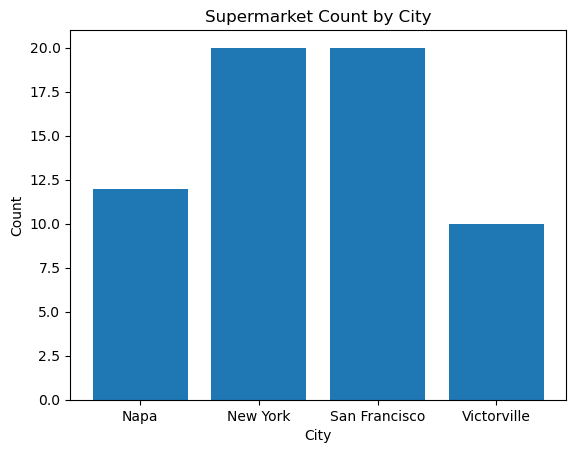

In [243]:
plt.bar(city_count["City"], city_count["Supermarket_Count"])
plt.title("Supermarket Count by City")
plt.xlabel("City")
plt.ylabel("Count")
plt.show()

In [244]:
#Total Population count by city 
population_count = supermarkets_density_final.groupby(["City"])["Population"].sum().reset_index()
population_count

,City,Population
0,Napa,94258.0
1,New York,693522.0
2,San Francisco,571917.0
3,Victorville,108430.0


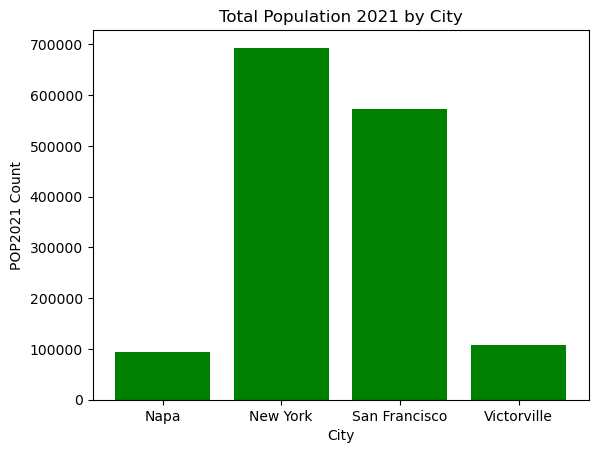

In [245]:
plt.bar(population_count["City"], population_count["Population"], color="green")
plt.title("Total Population 2021 by City")
plt.xlabel("City")
plt.ylabel("POP2021 Count")
plt.show()

In [246]:
poverty_total = supermarkets_density_final.groupby(["City"])["Poverty Count"].sum().reset_index()
poverty_total

,City,Poverty Count
0,Napa,7097.0
1,New York,165005.0
2,San Francisco,56718.0
3,Victorville,19052.0


In [247]:
final_two = pd.merge(
    city_count,
    population_count,
    how = "left",
    on = ["City", "City"]
)
final_two

,City,Supermarket_Count,Population
0,Napa,12,94258.0
1,New York,20,693522.0
2,San Francisco,20,571917.0
3,Victorville,10,108430.0


In [248]:
Customers_per_store = (final_two["Population"]/final_two["Supermarket_Count"])
Customers_per_store 

0     7854.833333
1    34676.100000
2    28595.850000
3    10843.000000
dtype: float64

In [249]:
final_three = pd.merge(
    final,
    poverty_rate,
    how = "left",
    on = ["City", "City"]
)
final_three

,City,Supermarket_Count,Population,Poverty Count
0,Napa,12,94258.0,7097.0
1,New York,20,693522.0,165005.0
2,San Francisco,20,571917.0,56718.0
3,Victorville,10,108430.0,19052.0


In [250]:
poverty_percentage_rate = (final_three["Poverty Count"]/final_three["Population"]) * 100
poverty_percentage_rate

0     7.529334
1    23.792324
2     9.917173
3    17.570783
dtype: float64

In [251]:
final_three["Poverty percentage rate"] = poverty_percentage_rate
final_three["Customers served per store"] = Customers_per_store 
final_three

,City,Supermarket_Count,Population,Poverty Count,Poverty percentage rate,Customers served per store
0,Napa,12,94258.0,7097.0,7.529334,7854.833333
1,New York,20,693522.0,165005.0,23.792324,34676.100000
2,San Francisco,20,571917.0,56718.0,9.917173,28595.850000
3,Victorville,10,108430.0,19052.0,17.570783,10843.000000
